# MIE1613 Project Experiment #5 - Risk of overshooting 2030 target
Here I use the simulation to answer question 2 of the report: <i>What is the risk of overshooting Canada's emission target within different scenarios?</i>, now under pessimistic scenarios

In [2]:
# Import Libraries
# Data
import numpy as np
import scipy as sp
from scipy import stats
import pandas as pd
import random

import re
from copy import deepcopy
#from tqdm import tqdm
import tqdm.notebook as tq

#Viz
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
import seaborn as sns
sns.set(font='Helvetica') # Futura? Calibri Light? 
sns.set_style("white")
sns.set_theme(style='ticks')
sns.set_context('talk')

## Preliminary Exercise: I calculate a downscaled version of Canada's 2030 emission target for residential energy and construction
Canada's 2005 inventory: https://publications.gc.ca/collections/collection_2008/ec/En81-4-2005E.pdf <br>
-> pdf page 105 (73): Canada's residential emissions were 44 MtCO2e * 0.6 = 26.4 = $\tau$
We would like to estimate P($\theta > \tau$) <br>
To do this we will sample 2030 for a higher number of replications

In [3]:
tau = 26.4

## Import
The simulation object and the required input data (emissions data and housing sample paths) <br>
<b> Important </b> -> the importer factor range is modified for sensitivity analysis: there are three values: min, most likely, max.

In [4]:
# Simulation object
from packages.project_package.mie_importer import *
from packages.project_package.mie_simulation import *

In [35]:
# Emissions data
Impr = MIEImporter()
Impr.factor_range = 'max'

Impr.e_path = 'data/input_data/embodied_'+Impr.factor_range+'_conservative.csv'
Impr.o_path = 'data/input_data/operational_intensity_2020_2050_conservative.csv'
embodied_data, operational_data = Impr.import_emission_data()

# Housing sample paths: 6000 exist for each scenario.
starts_data_lg3 = pd.read_csv('data/input_data/starts_samplepaths_bayesian_lg3.csv', index_col=0)
starts_data_mg6 = pd.read_csv('data/input_data/starts_samplepaths_bayesian_mg6.csv', index_col=0)
starts_data_hg10 = pd.read_csv('data/input_data/starts_samplepaths_bayesian_hg10.csv', index_col=0)

Importer created. Change self.factor_range for sensitivity analysis before importing.


In [36]:
embodied_data

,GHG Quantity 1 Max,Units,mm_split_labels,labels_general,ghg_per_unit,year
Building Key,,,,,,
1,128060.04740,1,Single Family,Single Family,128060.04740,2023
2,40827.63253,1,Single Family,Single Family,40827.63253,2023
3,77069.93919,1,Single Family,Single Family,77069.93919,2023
4,40484.37912,1,Single Family,Single Family,40484.37912,2023
7,65958.05891,1,Single Family,Single Family,65958.05891,2023
...,...,...,...,...,...,...
86,339200.00000,210,Mid High Rise,Mid High Rise,26486.57035,2050
87,339200.00000,545,Mid High Rise,Mid High Rise,24308.61673,2050
90,339200.00000,363,Mid High Rise,Mid High Rise,18329.36241,2050


## Simulate
Create an instance of the simulation object and run the simulation for all of the starts sample paths. Use common random numbers for each loop (the starts sample paths will be shared across each rep as well). <br>
For experiment four, we only want to simulate the year 2030, but we need the construction from the previous years to calculate embodied emissions. I create a modified simulation function that takes in the yearly construction as well as the cumulative, and uses these to quickly calculate the impacts in any given year. This will speed up this analysis and the optimization over the chain work.

In [37]:
# init
Simr = MIESimulation()
Simr.e_data = embodied_data
Simr.o_data = operational_data
# share of low, middle, high: BAU construction in canada is around 40%, 30%, 30% (see FIG bau)
Simr.nlmh = [0.4, 0.3, 0.3]
Simr.year = 2030

Sim object created. Initialize self.e_data and self.o_data


In [38]:
# single year using the simulation object
def single_year_simulation(b, b_cumulative):
    """
    Will calculate the emissions for self.year
    including cumulative operational emissions.
    b = houses built in year y
    b_cumulative = houses built in years 1->y
    """
    # ---FIT INPUT DATA---
    # MLE for embodied, factor for operational
    embodied_params_i = Simr.embodied_fitter_mle(data=Simr.e_data.loc[Simr.e_data['year']==Simr.year], 
                                                    distribution=Simr.e_distribution)
    operational_factor_i = Simr.get_operational_factor(operational_df=Simr.o_data, 
                                                        year=Simr.year)

    # get the number of starts for each housing type in 2030
    n_lmh_2030 = Simr.split_n_lmh(n=b, l=Simr.nlmh[0], m=Simr.nlmh[1], h=Simr.nlmh[2])
    # get the cumulative starts to 2030
    n_lmh_2030_cumulative = Simr.split_n_lmh(n=b_cumulative, l=Simr.nlmh[0], m=Simr.nlmh[1], h=Simr.nlmh[2])


    # ---SIMULATE: BUILD HOUSES, CALC PERFORMANCE VARIABLES---
    # embodied emissions for the given year
    embodied_i = Simr.build_embodied_lmh(n=b, e_params_dict=embodied_params_i,
                                            distribution=Simr.e_distribution,
                                            l=Simr.nlmh[0], m=Simr.nlmh[1], h=Simr.nlmh[2])

    # operational emissions of cumulative houses built
    operational_i = Simr.build_operational_lmh(n=b_cumulative, o_factor_dict=operational_factor_i,
                                                l=Simr.nlmh[0], m=Simr.nlmh[1], h=Simr.nlmh[2])

    # ---STORE OUTPUTS---
    # full data
    raw = {'year':Simr.year,
                'embodied':embodied_i, 
                'operational_y':operational_i,
                'num_built':n_lmh_2030_cumulative}

    # emissions each year
    embodied = embodied_i['Single Family']+embodied_i['Missing Middle']+embodied_i['Mid High Rise']
    operational = operational_i['Single Family']+operational_i['Missing Middle']+operational_i['Mid High Rise']

    # number built
    built = n_lmh_2030_cumulative['Single Family'] + n_lmh_2030_cumulative['Missing Middle'] + n_lmh_2030_cumulative['Mid High Rise']

    return {'raw':raw, 'E_e':embodied, 'E_o':operational, 'B':built}

In [39]:
starts_i_lg = starts_data_lg3.loc[0,'2023':'2050'].values.astype(int)

# 2030 starts
b_2030 = starts_data_lg3.loc[0,'2030'].astype(int)
b_2030_cum = starts_data_lg3.loc[0,'2023':'2030'].values.sum().astype(int)
print(b_2030)
print(b_2030_cum)

235545
1855480


In [40]:
embodied_lg = []
operational_lg = []
built_chain_lg = []

embodied_mg = []
operational_mg = []
built_chain_mg = []

embodied_hg = []
operational_hg = []
built_chain_hg = []

# Fix seed for common random numbers
np.random.seed(Simr.seed)

replications = 5000
# Simulation loop -> for low, medium, and high growth
for i in range(replications):
    print('iter',i)
    b_2030_lg = starts_data_lg3.loc[i,'2030'].astype(int)
    b_2030_cum_lg = starts_data_lg3.loc[i,'2023':'2030'].values.sum().astype(int)
    b_2030_mg = starts_data_mg6.loc[i,'2030'].astype(int)
    b_2030_cum_mg = starts_data_mg6.loc[i,'2023':'2030'].values.sum().astype(int)
    b_2030_hg = starts_data_hg10.loc[i,'2030'].astype(int)
    b_2030_cum_hg = starts_data_hg10.loc[i,'2023':'2030'].values.sum().astype(int)

    emit_i_lg = single_year_simulation(b_2030_lg, b_2030_cum_lg)
    emit_i_mg = single_year_simulation(b_2030_mg, b_2030_cum_mg)
    emit_i_hg = single_year_simulation(b_2030_hg, b_2030_cum_hg)

    # store output
    embodied_lg.append(np.array(emit_i_lg['E_e'])*1e-9)
    operational_lg.append(np.array(emit_i_lg['E_o'])*1e-9)
    built_chain_lg.append(np.array(emit_i_lg['B']))

    embodied_mg.append(np.array(emit_i_mg['E_e'])*1e-9)
    operational_mg.append(np.array(emit_i_mg['E_o'])*1e-9)
    built_chain_mg.append(np.array(emit_i_mg['B']))

    embodied_hg.append(np.array(emit_i_hg['E_e'])*1e-9)
    operational_hg.append(np.array(emit_i_hg['E_o'])*1e-9)
    built_chain_hg.append(np.array(emit_i_hg['B']))

iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
iter 10
iter 11
iter 12
iter 13
iter 14
iter 15
iter 16
iter 17
iter 18
iter 19
iter 20
iter 21
iter 22
iter 23
iter 24
iter 25
iter 26
iter 27
iter 28
iter 29
iter 30
iter 31
iter 32
iter 33
iter 34
iter 35
iter 36
iter 37
iter 38
iter 39
iter 40
iter 41
iter 42
iter 43
iter 44
iter 45
iter 46
iter 47
iter 48
iter 49
iter 50
iter 51
iter 52
iter 53
iter 54
iter 55
iter 56
iter 57
iter 58
iter 59
iter 60
iter 61
iter 62
iter 63
iter 64
iter 65
iter 66
iter 67
iter 68
iter 69
iter 70
iter 71
iter 72
iter 73
iter 74
iter 75
iter 76
iter 77
iter 78
iter 79
iter 80
iter 81
iter 82
iter 83
iter 84
iter 85
iter 86
iter 87
iter 88
iter 89
iter 90
iter 91
iter 92
iter 93
iter 94
iter 95
iter 96
iter 97
iter 98
iter 99
iter 100
iter 101
iter 102
iter 103
iter 104
iter 105
iter 106
iter 107
iter 108
iter 109
iter 110
iter 111
iter 112
iter 113
iter 114
iter 115
iter 116
iter 117
iter 118
iter 119
iter 120
iter 121
iter 122
ite

## Analysis
We just want an estimator for yearly emissions in 2030, so isolate that data

In [41]:
# calculate combined emissions from energy and operational
emission_2030_lg = np.array(embodied_lg) + np.array(operational_lg)
emission_2030_mg = np.array(embodied_mg) + np.array(operational_mg)
emission_2030_hg = np.array(embodied_hg) + np.array(operational_hg)

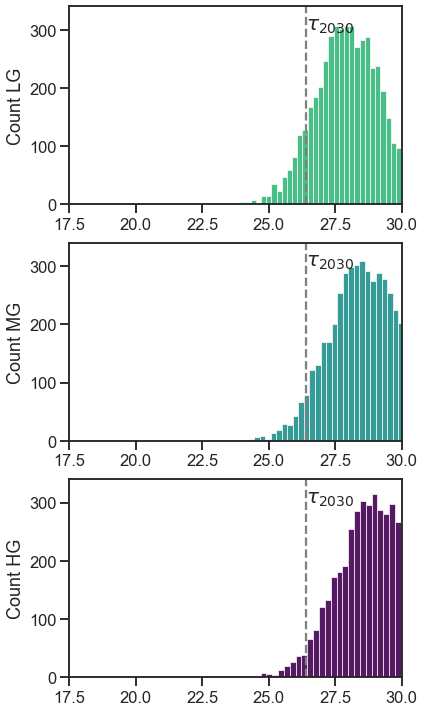

In [42]:
fig, ax = plt.subplots(3,1, figsize=(6,10))
sns.histplot(emission_2030_lg, ax=ax[0], color='#35b779', alpha=0.9)
sns.histplot(emission_2030_mg, ax=ax[1], color='#21918c', alpha=0.9)
sns.histplot(emission_2030_hg, ax=ax[2], color='#440154', alpha=0.9)

m = ['Count LG', 'Count MG', 'Count HG']
for i, a in enumerate(ax.reshape(-1)):
    a.set_ylabel(m[i])
    a.set_ylim([0,340])
    a.set_xlim([17.5,30])
    a.vlines(tau, 0,400, colors='grey', linestyles='--')
    a.text(tau,300,'$\\tau_{2030}$', fontsize=20)

plt.tight_layout()

expected value

In [43]:
print('95% CI for mean cumulative emissions - LOW GROWTH:', np.mean(emission_2030_lg), "+/-",
       1.96*np.std(emission_2030_lg, ddof = 1)/np.sqrt(replications))
print('95% CI for mean cumulative emissions - MEDIUM GROWTH:', np.mean(emission_2030_mg), "+/-",
       1.96*np.std(emission_2030_mg, ddof = 1)/np.sqrt(replications))
print('95% CI for mean cumulative emissions - HIGH GROWTH:', np.mean(emission_2030_hg), "+/-",
       1.96*np.std(emission_2030_hg, ddof = 1)/np.sqrt(replications))

95% CI for mean cumulative emissions - LOW GROWTH: 28.00795823581729 +/- 0.034794451130710106
95% CI for mean cumulative emissions - MEDIUM GROWTH: 28.601271048947837 +/- 0.037285603903790175
95% CI for mean cumulative emissions - HIGH GROWTH: 29.059806189305277 +/- 0.03922850882237662


p(theta bigger than tau)

In [44]:
theta_lg = np.int64(emission_2030_lg>tau)
theta_mg = np.int64(emission_2030_mg>tau)
theta_hg = np.int64(emission_2030_hg>tau)

print('95% CI for exceeded emission target - LOW GROWTH:', theta_lg.mean(), "+/-",
       1.96*np.std(theta_lg, ddof = 1)/np.sqrt(replications),
       'RSE:', (np.std(theta_lg, ddof = 1)/np.sqrt(replications))/theta_lg.mean()
       )
print('95% CI for exceeding emission target - MEDIUM GROWTH:', theta_mg.mean(), "+/-",
       1.96*np.std(theta_mg, ddof = 1)/np.sqrt(replications),
       'RSE:', (np.std(theta_mg, ddof = 1)/np.sqrt(replications))/theta_mg.mean()
       )
print('95% CI for exceeding emissiont target - HIGH GROWTH:', theta_hg.mean(), "+/-",
       1.96*np.std(theta_hg, ddof = 1)/np.sqrt(replications),
       'RSE:', (np.std(theta_hg, ddof = 1)/np.sqrt(replications))/theta_hg.mean()
       )

95% CI for exceeded emission target - LOW GROWTH: 0.9006 +/- 0.008294184016677017 RSE: 0.004698785852899097
95% CI for exceeding emission target - MEDIUM GROWTH: 0.952 +/- 0.005925890140290398 RSE: 0.003175854345465185
95% CI for exceeding emissiont target - HIGH GROWTH: 0.9704 +/- 0.004698245997379275 RSE: 0.0024701816615593374
